In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords

In [2]:
sns.set_style("whitegrid")

## Quais são os produtos mais catalogados? V
## Quais produtos tem mais unidades vendidas? V
## Qual o preço médio dos produtos? V
## Qual a receita dos produtos? V
## Qual material é mais vendido? Qual é menos vendido? V
## Os kits de itens mostram diferença nas vendas e valor?
## O valor do desconto tem relação com o número de vendas?
## Como é a avaliação dos clientes


In [3]:
def plota_variaveis_numericas(dataframe: pd.DataFrame, conjunto: list, alvo: str, titulo: str, modo='barra', tamanho_figura = (15,30), i=0) -> None:
    nrows = int(round(len(conjunto)/2, 0))
    
    if nrows < (len(conjunto)/2):
        nrows += 1

    fig, axes = plt.subplots(ncols=2, nrows=nrows, figsize=tamanho_figura, facecolor='white')
    axes = axes.flatten()
    fig.suptitle(titulo)
    #fig.subplots_adjust(hspace=0.8, wspace=0.3)


    for item in conjunto:
        if modo == 'barra':
            sns.barplot(x=dataframe[alvo], y=dataframe[item], ax=axes[i], color='#435058')
            axes[i].set_title(item)

        elif modo=='histograma':
            sns.histplot(x=dataframe[item], ax=axes[i], color='#435058')
            axes[i].axvline(x=dataframe[item].mean(), linestyle='--', color='red')
            axes[i].axvline(x=dataframe[item].median(), linestyle='--', color='green')
            axes[i].set_title(item + '. Média = {:.2f}, Mediana = {:.2f}'.format(dataframe[item].mean(), dataframe[item].median()))

        if dataframe[item].nunique() > 6:
            axes[i].xaxis.set_tick_params(rotation=90)

        axes[i].set_ylabel('')
        axes[i].set_xlabel('')
        i += 1
   
    fig.tight_layout(pad=2)

def plota_contagens(dataframe: pd.DataFrame, conjunto: list, alvo: str, titulo: str, tamanho_figura = (15,22), i=0) -> None:
    nrows = int(round(len(conjunto)/2, 0))

    if nrows < (len(conjunto)/2):
        nrows += 1

    fig, axes = plt.subplots(ncols=2, nrows=nrows, figsize=tamanho_figura, facecolor='white')
    axes = axes.flatten()
    fig.suptitle(titulo)

    for item in conjunto:
        sns.countplot(x=dataframe[item], ax=axes[i], palette='Paired', hue=dataframe[alvo])
        axes[i].set_title(item)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('')
        i += 1
        
    fig.tight_layout(pad=2)


def plota_dispersao(dataframe: pd.DataFrame, conjunto: list, var: str, titulo: str, legenda=None, tamanho_figura = (20,12), i=0) -> None:
    nrows = int(round(len(conjunto)/2, 0))

    if nrows < (len(conjunto)/2):
        nrows += 1

    fig, axes = plt.subplots(ncols=2, nrows=nrows, figsize=tamanho_figura, facecolor='white')
    axes = axes.flatten()
    fig.suptitle(titulo)


    for item in conjunto:
        if legenda is not None:
            sns.scatterplot(x=dataframe[var], y=dataframe[item], ax=axes[i], hue=dataframe[legenda])
        else:
            sns.scatterplot(x=dataframe[var], y=dataframe[item], ax=axes[i])

        i += 1
    fig.tight_layout(pad=2)

def tipifica_roupa(valor):
    for item in pecas:
        if item in valor:
            return item
    
    return 'outros'

def verifica_kit(valor):
    if "kit" in valor:
        return True
    else:
        return False

In [4]:
df = pd.read_csv('dataset_roupas_marketplacebr_limpo.csv')

In [5]:
df.head()
df = df.drop_duplicates()
df = df.drop(['Unnamed: 0'], axis=1)

In [6]:
textos = ' '.join(df['Título'])
palavras = textos.lower().split()
palavras = [palavra for palavra in palavras if palavra not in stopwords.words('portuguese')]
palavras = [palavra for palavra in palavras if len(palavra) > 3]

In [7]:
word_count = Counter(palavras)

print(word_count.most_common(100))

[('roupa', 583), ('infantil', 402), ('calça', 396), ('jeans', 333), ('short', 271), ('feminina', 250), ('masculina', 247), ('conjunto', 231), ('feminino', 223), ('bermuda', 207), ('roupas', 190), ('alta', 189), ('cintura', 187), ('plus', 165), ('size', 163), ('bebê', 154), ('shorts', 152), ('lycra', 149), ('academia', 142), ('algodão', 135), ('cuecas', 125), ('masculino', 124), ('atacado', 122), ('menino', 116), ('boxer', 105), ('menina', 105), ('peças', 102), ('lupo', 92), ('ballet', 88), ('body', 82), ('saia', 81), ('moda', 81), ('fitness', 80), ('bumbum', 76), ('original', 67), ('moletom', 67), ('blusa', 66), ('praia', 62), ('tactel', 61), ('costura', 59), ('térmica', 59), ('verão', 59), ('juvenil', 57), ('bermudas', 53), ('premium', 52), ('manga', 52), ('adulto', 52), ('uniforme', 50), ('estampado', 50), ('proteção', 50), ('femininas', 50), ('elastano', 49), ('bebe', 49), ('jogger', 48), ('levanta', 48), ('segunda', 44), ('pele', 44), ('macacão', 44), ('apicultor', 43), ('azul', 42

In [8]:
pecas = ['calça', 'short', 'conjunto', 'bermuda', 'shorts', 'cuecas', 'ballet', 'body', 'saia', 'blusa', 'bermudas', 'uniforme', 'macacão',
         'cueca', 'camiseta', 'meia', 'calças', 'conjuntos', 'mala', 'cinto', 'pijama', 'camisa', 'boné']

In [9]:
df['Título'] = df['Título'].apply(lambda x: x.lower())
df['tipo_roupa'] = df['Título'].apply(tipifica_roupa)
df['kit'] = df['Título'].apply(verifica_kit)
df['receita_prod'] = df['Preco_com_desconto']*df['n_vendidos_categoria']

<AxesSubplot: title={'center': 'Número de anúncios por tipo de produto'}, xlabel='tipo_roupa'>

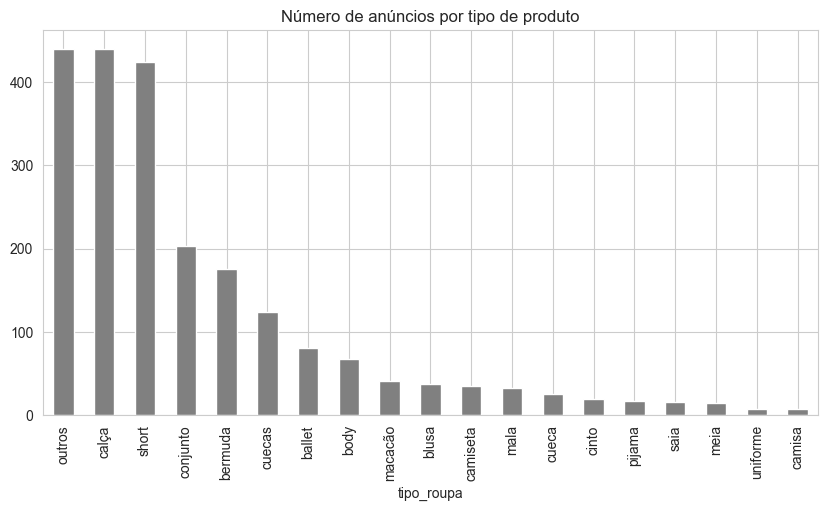

In [10]:
df['tipo_roupa'].value_counts().plot(kind='bar', color='gray', figsize=(10, 5), title='Número de anúncios por tipo de produto')

<AxesSubplot: title={'center': 'Vendas por categoria do produto'}, xlabel='tipo_roupa'>

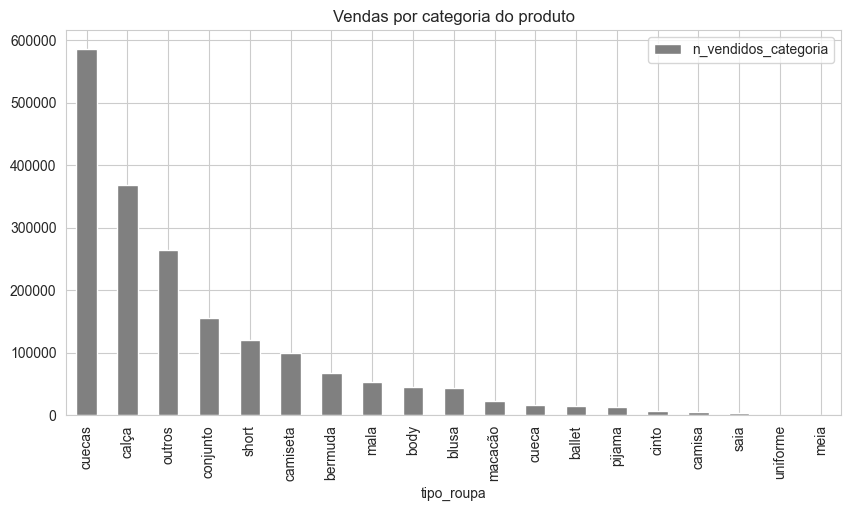

In [11]:
df[['tipo_roupa','n_vendidos_categoria']].groupby('tipo_roupa').sum().sort_values(by='n_vendidos_categoria', ascending=False)\
    .plot(kind='bar', color='gray', figsize=(10, 5), title='Vendas por categoria do produto')

In [12]:
df.head()

,Título,Preco_original,Desconto_percentual,Preco_com_desconto,n_vendidos_categoria,Marca,Material,Gênero,Temporada,Nota,N_Avaliações,Review1,Review2,Review3,tipo_roupa,kit,receita_prod
0,pijama cirurgico scrub roupa privativa hospit...,69.90,0.00,69.90,1000,TORONTO UNIFORMES PROFISSIONAIS,Poliéster,Sem gênero,NaN,4.0,273,"Preço justo , bem feito acabamento ok. Única s...","Tamanho bom, costuras de qualidade, porém teci...","Muito bom, só poderia ter os cortes na lateral...",pijama,False,69900.0
1,kit 10 cuecas boxer lupo cueca box algodão mas...,274.81,0.18,232.89,10000,Lupo,Algodão,Masculino,Outono/Inverno,4.5,3034,As cuecas são boas; porém você percebe na cost...,"Pelo preço promocional, com ctz tem algum defe...","Serviram muito bem, porém é nítido que o pano ...",cuecas,True,2328900.0
2,kit com 10 cuecas boxer algodão sem costura zo...,239.88,0.20,199.90,50000,Zorba,Algodão,Masculino,NaN,4.7,5682,O tecido é bom e são confortáveis. Só que a nu...,Vendo comentários de outros consumidores vejo ...,"Produto não é nem de longe original, tecido gr...",cuecas,True,9995000.0
3,kit 10 cuecas boxer mash algodão cotton box or...,279.86,0.22,229.39,10000,Mash,Algodão,Masculino,Primavera/Verão,4.6,1700,"As cuecas são boas, porém meu marido usa g e p...","E o tamanho certo, mas em baixo dela, fica mui...",Produto não parece.\nOriginal e veio 2 modelos...,cuecas,True,2293900.0
4,kit 3 short jeans feminino cintura alta barato...,140.83,0.09,129.20,1000,Menina Linda,Jean,Feminino,Primavera/Verão,4.4,507,Estou encantada com essas peças!.\nOs shorts s...,"Recomendo, tecido confortável, igual a foto.","Gostei muito dos shorts, material bom, para us...",short,True,129200.0


<AxesSubplot: title={'center': 'Receita total por categoria do produto'}, xlabel='tipo_roupa'>

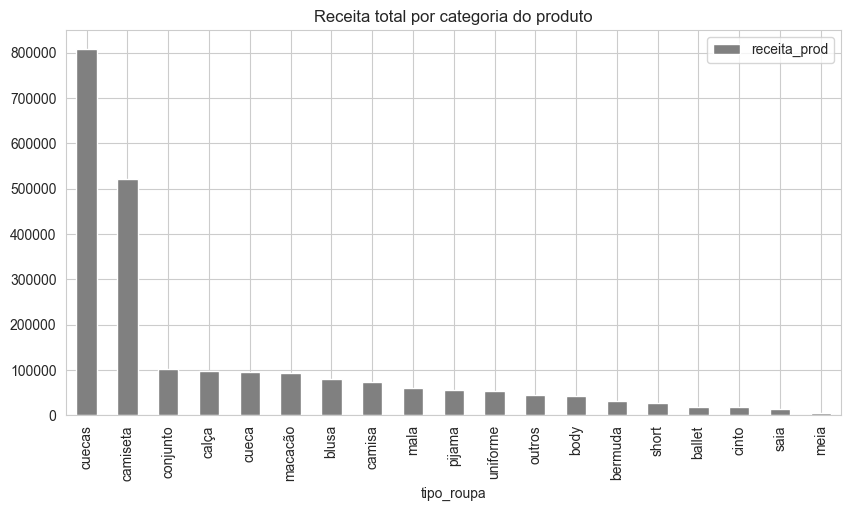

In [17]:
df[['tipo_roupa','receita_prod']].groupby('tipo_roupa').mean().sort_values(by='receita_prod', ascending=False)\
    .plot(kind='bar', color='gray', figsize=(10, 5), title='Receita total por categoria do produto')

In [14]:
df_categoria_medias = df.groupby('tipo_roupa').mean(numeric_only=True).sort_values(by='Preco_com_desconto', ascending=False)
df_categoria_somas = df.groupby('tipo_roupa').sum(numeric_only=True).sort_values(by='receita_prod', ascending=False)

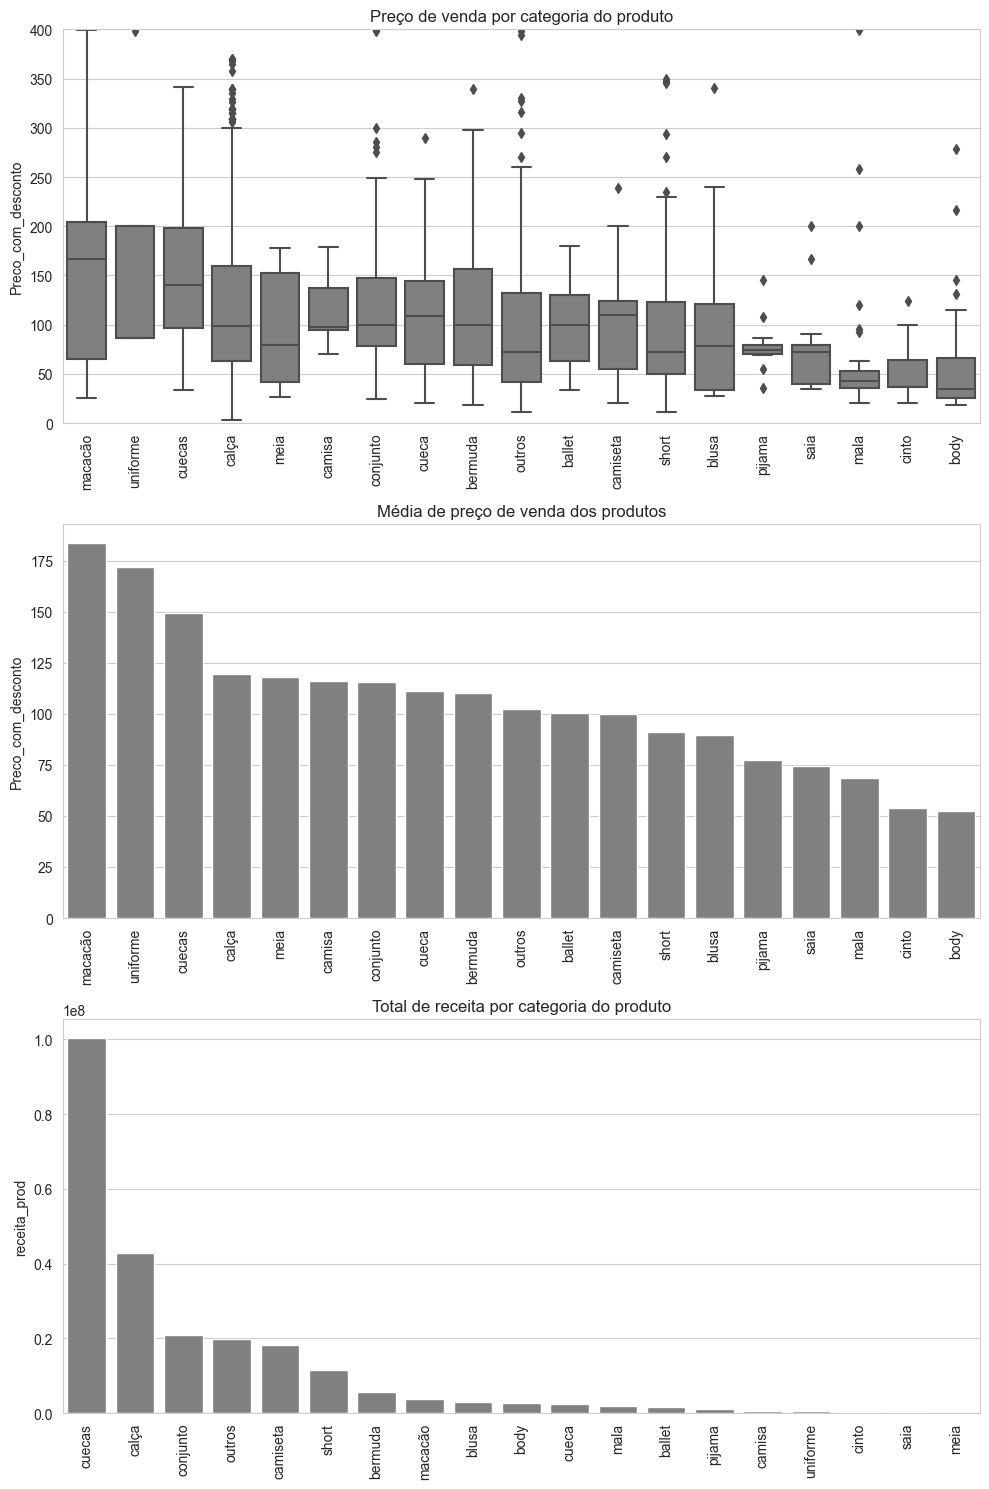

In [40]:
mean_values = df.groupby('tipo_roupa')['Preco_com_desconto'].mean().sort_values(ascending=False)

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
sns.boxplot(x=df['tipo_roupa'], y=df['Preco_com_desconto'].sort_values(ascending=False), data=df, ax=axs[0], color='gray', order=mean_values.index)
sns.barplot(x=df_categoria_medias.index, y=df_categoria_medias['Preco_com_desconto'].sort_values(ascending=False), data=df, ax=axs[1], color='gray')
sns.barplot(x=df_categoria_somas.index, y=df_categoria_somas['receita_prod'], data=df_categoria_somas, ax=axs[2], color='gray')



axs[0].set_title('Preço de venda por categoria do produto')
axs[1].set_title('Média de preço de venda dos produtos')
axs[2].set_title('Total de receita por categoria do produto')

for i in range(3):
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    axs[i].set_xlabel('')
axs[0].set_ylim([0,400])

fig.tight_layout()

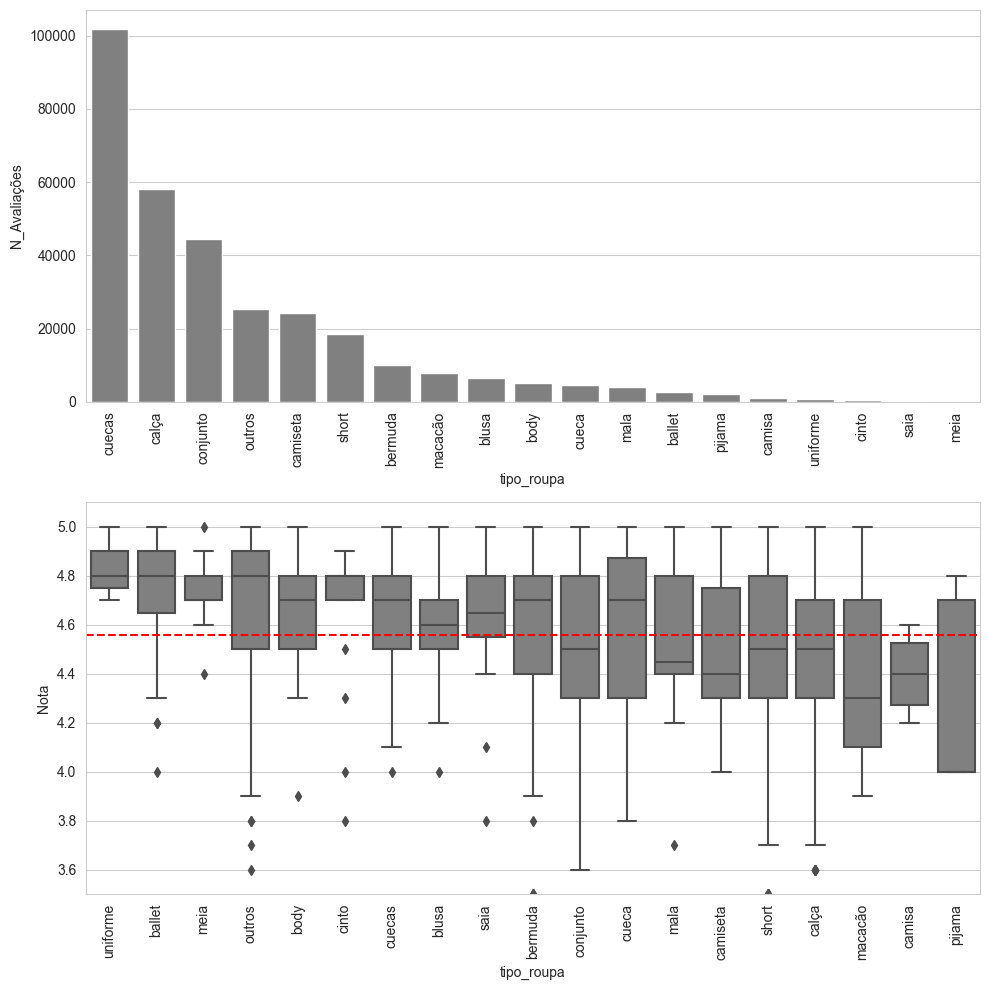

In [43]:
mean_values = df.groupby('tipo_roupa')['Nota'].mean().sort_values(ascending=False)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

sns.barplot(x=df_categoria_somas.index, y=df_categoria_somas['N_Avaliações'].sort_values(ascending=False), data=df_categoria_somas, ax=axs[0], color='gray')
sns.boxplot(x=df['tipo_roupa'], y=df['Nota'].sort_values(ascending=False), data=df, color='gray', ax=axs[1], order=mean_values.index)

axs[1].axhline(y=df['Nota'].mean(), color='red', linestyle='--')
axs[1].set_ylim([3.5,5.1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

fig.tight_layout()


In [95]:
v_num = df.select_dtypes(include=['int', 'float']).columns.to_list()